# FFT

- [Library and FFT function](#library-and-fft-function)
- [Power calculation](#power-calculation)
- [Signal generation using numpy](#signal-generation-using-numpy)
- [Signal to file](#signal-to-file)
- [Signal generation from file](#signal-generation-from-file)
- [Signal generation from iq file](#signal-generation-from-iq-file)
- [Main processing](#main-processing)
- [Graph](#graph)

## Library and FFT function

必要なライブラリを読み込む。
Import necessary libraries.

関数は、scipyのFFT関数を使いやすくしている。
The function below makes FFT in Scipy easier to use.

In [66]:
from matplotlib import markers
import numpy as np
import math
from scipy import fftpack
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline

# Function of FFT
def calc_fft(data, samplerate):
    spectrum = fftpack.fft(data)                                    # FFT process
    amp = np.sqrt((spectrum.real ** 2) + (spectrum.imag ** 2))      # Amplitude
    amp = amp / (len(data) / 2)                                     # normalization of Amplitude
    phase = np.arctan2(spectrum.imag, spectrum.real)                # Phase calculation
    phase = np.degrees(phase)                                       # convert phase to radian
    freq = np.linspace(0, samplerate, len(data))                    # X_in_Freq
    return spectrum, amp, phase, freq

# Function of FFTshift
def calc_fftshift(data, N, FFT_bin):
    shifted_spectrum = fftpack.fftshift(spectrum)
    shifted_sample_index = np.arange(-N//2, N//2)
    shifted_freq = shifted_sample_index*FFT_bin

    shifted_amp = np.sqrt((shifted_spectrum.real ** 2) + (shifted_spectrum.imag ** 2))
    shifted_amp = shifted_amp / (N / 2)  
    return shifted_spectrum, shifted_freq, shifted_amp

# FFT calling function
def main_FFT_processing(y_in_time, sampling_freq):
    # Call FFT function
    spectrum, amp, phase, freq = calc_fft(y_in_time, sampling_freq)
    
    return spectrum, amp, phase, freq

# Shift-FFT calling function
def main_shiftFFT_processing(spectrum, sampling_freq, N):

    # calculate bins
    FFT_bin = sampling_freq / N
    time_bin = 1 / FFT_bin

    # Call FFTshift function
    shifted_spectrum, shifted_freq, shifted_amp = calc_fftshift(spectrum, N, FFT_bin)
    
    return FFT_bin, time_bin, shifted_spectrum, shifted_freq, shifted_amp

# dBFS
def generate_dbFS(amp, ADC_input_range):
    
    # Make amp[V] into amp[dB]
    ampdb = [20 * math.log10(val/ADC_input_range) for val in amp]

    return ampdb

## Power calculation

## Signal generation using numpy

- sampling_freq: サンプリング周波数 (sampling frequency)
- sampling_time: サンプリングレート (sampling rate)
- main_amp: 被測定信号の電圧 (amplitude of the signal of interest)
- main_frequency: 被測定信号の周波数 (frequency of the signal of interest)
- start_time: 測定開始時間 (time of start)
- stop_time: 測定終了時間 (time of end)
- x_in_time: np.array, 時間方向のデータ (x data in time)
- y_in_time: np.array, 振幅方向のデータ (y data in time)

ここで、y_in_timeは、片側だけの信号なので、2倍する処理をかけて差動とみなしている。
y_in_time is one arm of differential signal. need to double it to convert single end to differential

In [67]:
sampling_freq = 128e6
sampling_time = 1 / sampling_freq

main_amp = 0.252
main_frequency = 32e6

start_time = 0
N_cycle = 5
stop_time = (1/main_frequency)*N_cycle

ADC_input_range = 0.5

# original
x_in_time = np.arange(start_time, stop_time, sampling_time)
y_in_time = main_amp * np.cos(2 * np.pi * main_frequency * x_in_time) # single-end
y_in_time = 2*y_in_time # differential

# x_in_time = np.arange(start_time, stop_time, sampling_time)
# real = np.array(main_amp * np.cos(2 * np.pi * main_frequency * x_in_time))
# imag = np.array(main_amp * np.sin(2 * np.pi * main_frequency * x_in_time))

# tmp = []
# for x, y in zip(real, imag):
#     tmp.append(complex(x,y))
# y_in_time = np.array(tmp)

# y_in_time = 2*y_in_time # differential


Sampling_point = len(x_in_time) # Sample count

## Signal to file

生成した信号をファイルに持っていって、ファイルから読み出せるようにする。
write signal data into a file in order to read it later.

In [68]:
import csv

with open('signal_data.csv', 'w', newline='') as fp:
    writer = csv.writer(fp)
    writer.writerow(['time[s]', 'amplitude[v]'])
    for x in zip(x_in_time, y_in_time):
        writer.writerow(x)

### Signal file to IQ data

普通のCW波形を作りたいならば、Iだけ、もしくはQだけのデータを作成するれば良い。
if you want to make CW signal, you don't need to prepare I and Q data. only one data is enough.

結局の所、CWに取って大切になるのは振幅情報だ。あとは、各データポイントのサンプリングレートがあれば、FFTできるはずである。
The thing is that amplitude of the main signal matters for CW signal.
(Plus, sampling rate. That's enough for FFT calculation)

この'signal_data_iq.csv'が、ADCから実際吐き出されるデータと想定して、このスクリプトの評価を行う。
So in this juypter note, treat 'signal_data_iq.csv' as ADC output. And checked it with these scripts.

In [69]:
import csv

with open('signal_data.csv', 'r') as fp:
    reader = csv.reader(fp)
    i = 0
    time = []
    ample = []
    for row in reader:
        if i == 0:
            i += 1
        else:
            ample.append(float(row[1]))
            
with open('signal_data_iq.csv', 'w', newline='') as fp:
    writer = csv.writer(fp)
    writer.writerow(['i', 'q'])
    for x in zip(ample, np.zeros(len(ample))):
        writer.writerow(x)

## Signal generation from file

ファイルから時間信号を再現する。この際にサンプリング周波数などの情報がないので、本当はヘッダーに書くのが良いと思う。
generate signal data from the file you read. Actually, there is no sampling frequency information in the file.
I think it would be better to have in it header of the file.

でもこのスクリプトでは、自分で定義しているので、その数字を使うだけに留める。
But in this script, I just defined these information by myself.

In [70]:
import csv

with open('signal_data.csv', 'r') as fp:
    reader = csv.reader(fp)
    i = 0
    time = []
    ample = []
    for row in reader:
        if i == 0:
            i += 1
        else:
            time.append(float(row[0]))
            ample.append(float(row[1]))

x_in_time = np.array(time)
y_in_time = np.array(ample)

# print(f'x_in_time: {x_in_time}')
# print(f'y_in_time: {y_in_time}')

## Signal generation from iq file

ファイルから時間信号を再現する。この際にサンプリング周波数などの情報がないので、本当はヘッダーに書くのが良いと思う。
generate signal data from the file you read. Actually, there is no sampling frequency information in the file.
I think it would be better to have in it header of the file.

本スクリプトでは、1行目がi, qと書いただけのヘッダーがあるので、読み込む際に無視している。
This script treat 1st line of the file as header and ignore it.

In [71]:
import csv

with open('signal_data_iq.csv', 'r') as fp:
    reader = csv.reader(fp)
    i = 0
    i_data = []
    q_data = []
    iq_data = []
    for row in reader:
        if i == 0:
            i += 1
        else:
            i_data.append(float(row[0]))
            q_data.append(float(row[1]))
            iq_data.append(complex(float(row[0]), float(row[1])))

## Main processing

メイン処理は、何をしているかと言うと、
What happened here in the main process are

- FFTをかける (do FFT)
- ADCのフルスケールに対して、何dBなのか振幅での処理を行う (scale and correct amplitude information)
- グラフのためのFFT binの計算 (calculate FFT bin)
- FFTのデータシフト (data shift in frequency region)
- 周波数軸上でのレベルの最大値を取得 (get max in amplitude)

である。
That's all.

In [72]:
# FFT Main
spectrum, amp, phase, freq = main_FFT_processing(y_in_time, sampling_freq)
FFT_bin, time_bin, shifted_spectrum, shifted_freq, shifted_amp = main_shiftFFT_processing(spectrum, sampling_freq, Sampling_point)

# Calculate dBFS
ampdb = generate_dbFS(amp, ADC_input_range)
shifted_ampdb = generate_dbFS(shifted_amp, ADC_input_range)

# Max value in ampdb
max_db = max(ampdb)
shifted_max_db = max(shifted_ampdb)  

# For Console
print(f"Sampling Freq : {sampling_freq} [Hz]")
print(f"Measured Freq : {main_frequency} [Hz]")
print(f"Sampling points : {Sampling_point} [-]")
print(f"FFT bin : {FFT_bin} [Hz]")
print(f"Time bin : {time_bin} [s]")
print(f"Sample Point : {len(x_in_time)} [point]")
print(f"Max AMP of data : {round(max_db,2)} [dBFS]")
print(f"Shifted max AMP of data : {round(shifted_max_db,2)} [dBFS]")

Sampling Freq : 128000000.0 [Hz]
Measured Freq : 32000000.0 [Hz]
Sampling points : 20 [-]
FFT bin : 6400000.0 [Hz]
Time bin : 1.5625e-07 [s]
Sample Point : 20 [point]
Max AMP of data : 0.07 [dBFS]
Shifted max AMP of data : 0.07 [dBFS]


## Graph

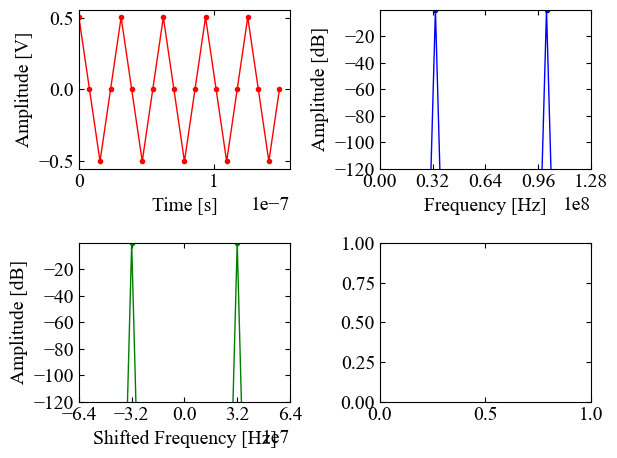

In [73]:
# For Graph
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'
 
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
 
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax2 = fig.add_subplot(222)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax3 = fig.add_subplot(223)
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_ticks_position('both')
ax4 = fig.add_subplot(224)
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
 
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude [V]')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude [dB]')
ax3.set_xlabel('Shifted Frequency [Hz]')
ax3.set_ylabel('Amplitude [dB]')
# ax4.set_xlabel('Time [s]')
# ax4.set_ylabel('Phase [deg]')
 
# Set scale
ax1.set_xlim(0, stop_time)

ax2.set_xticks(np.arange(0, sampling_freq+1, sampling_freq/4))
ax2.set_xlim(0, sampling_freq)
ax2.set_yticks(np.arange(-120, 0, 20))
ax2.set_ylim(-120, 0)

ax3.set_xticks(np.arange(-sampling_freq/2, sampling_freq/2+1, sampling_freq/4))
ax3.set_xlim(-sampling_freq/2, sampling_freq/2)
ax3.set_yticks(np.arange(-120, 0, 20))
ax3.set_ylim(-120, 0)

# ax4.set_xlim(0, stop_time)
# ax4.set_ylim(-180, 180)
 
# plot data with some settings
ax1.plot(x_in_time, y_in_time, label='Time waveform', lw=1, color='red', marker='.')
ax2.plot(freq, ampdb, label='Amplitude', lw=1, color='blue', marker='.')
ax3.plot(shifted_freq, shifted_ampdb, label='Amplitude', lw=1, color='green', marker='.')
# ax4.plot(x_in_time, phase, label='Amplitude', lw=1, color='green', marker='.')

# layout setting
fig.tight_layout()
 
# show graph
plt.show()
# ---------------------------------------------------


## Main processing for iq

In [74]:
# make y_in_time for iq file
y_in_time = [complex(x,y) for x,y in zip(i_data, q_data)]

# FFT Main
spectrum, amp, phase, freq = main_FFT_processing(y_in_time, sampling_freq)
FFT_bin, time_bin, shifted_spectrum, shifted_freq, shifted_amp = main_shiftFFT_processing(spectrum, sampling_freq, N)

# Calculate dBFS
ampdb = generate_dbFS(amp, ADC_input_range)
shifted_ampdb = generate_dbFS(shifted_amp, ADC_input_range)

# Max value in ampdb
max_db = max(ampdb)
shifted_max_db = max(shifted_ampdb)  

# For Console
print(f"Sampling Freq : {sampling_freq} [Hz]")
print(f"Measured Freq : {main_frequency} [Hz]")
print(f"Sampling points : {N} [-]")
print(f"FFT bin : {FFT_bin} [Hz]")
print(f"Time bin : {time_bin} [s]")
print(f"Sample Point : {len(x_in_time)} [point]")
print(f"Max AMP of data : {round(max_db,2)} [dBFS]")
print(f"Shifted max AMP of data : {round(shifted_max_db,2)} [dBFS]")

NameError: name 'N' is not defined

## Graph for iq

グラフは関数化すると良いかなと思う。
TODO: make this graph script as function later.

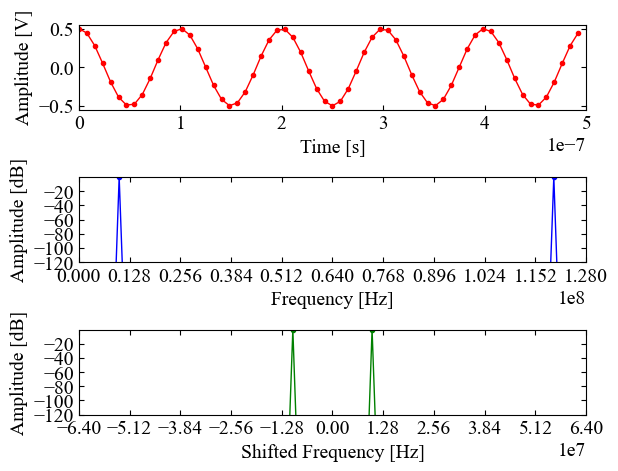

In [ ]:
# For Graph
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'
 
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
 
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax2 = fig.add_subplot(312)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax3 = fig.add_subplot(313)
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_ticks_position('both')
 
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Amplitude [V]')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Amplitude [dB]')
ax3.set_xlabel('Shifted Frequency [Hz]')
ax3.set_ylabel('Amplitude [dB]')
 
# Set scale
ax1.set_xlim(0, stop_time)
ax2.set_xticks(np.arange(0, sampling_freq+sampling_freq/10, sampling_freq/10))
ax2.set_xlim(0, sampling_freq)
ax2.set_yticks(np.arange(-120, 0, 20))
ax2.set_ylim(-120, 0)
ax3.set_xticks(np.arange(-sampling_freq/2, sampling_freq/2+sampling_freq/10, sampling_freq/10))
ax3.set_xlim(-sampling_freq/2, sampling_freq/2)
ax3.set_yticks(np.arange(-120, 0, 20))
ax3.set_ylim(-120, 0)
 
# plot data with some settings
ax1.plot(x_in_time, y_in_time, label='Time waveform', lw=1, color='red', marker='.')
ax2.plot(freq, ampdb, label='Amplitude', lw=1, color='blue', marker='.')
ax3.plot(shifted_freq, shifted_ampdb, label='Amplitude', lw=1, color='green', marker='.')

# layout setting
fig.tight_layout()
 
# show graph
plt.show()
# ---------------------------------------------------
